In [1]:
import sklearn
from sklearn.datasets import make_circles
import matplotlib.pyplot as plt
import torch
import numpy as np
from torch import nn

In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

# 1. Binary Classification

## 1. Data

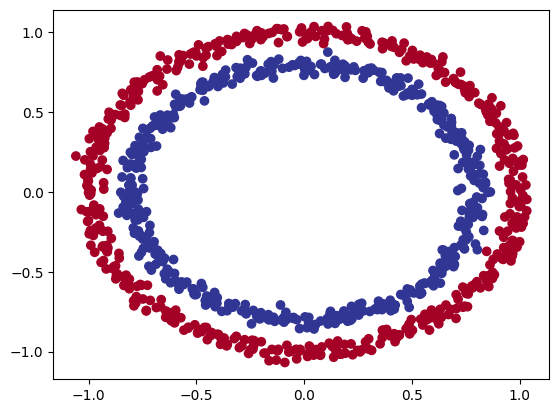

In [3]:
n_samples = 1000
X, y = make_circles(n_samples,
                    noise= 0.03,
                    random_state=42)
X = torch.from_numpy(X).type(torch.float32)
y = torch.from_numpy(y).type(torch.float32)

plt.scatter(x = X[:, 0], y = X[:, 1],
             c = y, cmap = plt.cm.RdYlBu)

## 2. Split

In [4]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.2, # 20%
                                                    random_state=42)

In [5]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

(torch.Size([800, 2]),
 torch.Size([200, 2]),
 torch.Size([800]),
 torch.Size([200]))

## 3. Model

In [6]:
class CircleModel(nn.Module):
  def __init__(self):
    super().__init__()
    self.l1 = nn.Linear(in_features=2, out_features=8)
    self.l2 = nn.Linear(in_features=8, out_features=1)

  def forward(self, x):
    return self.l2(self.l1(x))

In [7]:
model = nn.Sequential(
    nn.Linear(in_features=2, out_features=8),
    nn.Linear(in_features=8, out_features=1)
).to(device)
model.state_dict()

OrderedDict([('0.weight',
              tensor([[ 0.0013,  0.0329],
                      [ 0.2452,  0.6258],
                      [-0.0372,  0.6904],
                      [ 0.5359, -0.3708],
                      [-0.6356,  0.2371],
                      [-0.3754,  0.0609],
                      [ 0.2485,  0.3386],
                      [-0.5900,  0.0088]])),
             ('0.bias',
              tensor([-0.1047, -0.6860, -0.5431,  0.6538, -0.5949,  0.1164, -0.2346, -0.3405])),
             ('1.weight',
              tensor([[ 0.1582,  0.0315,  0.3059,  0.3301, -0.3348, -0.0016, -0.3064, -0.0321]])),
             ('1.bias', tensor([-0.1829]))])

## 4. Build Loss and Optimizer

In [8]:
loss_fn = nn.BCEWithLogitsLoss()

optimizer = torch.optim.SGD(
    params=model.parameters(),
    lr=0.1
)

In [9]:
def accuracy_fn(y_true, y_pred):
  correct = torch.eq(y_true, y_pred).sum().item()
  acc = (correct / len(y_pred)) * 100
  return acc

## 5. Training Loop

In [10]:
#@title Plot decision boundary
def plot_decision_boundary(model: torch.nn.Module, X: torch.Tensor, y: torch.Tensor):
    """Plots decision boundaries of model predicting on X in comparison to y.

    Source - https://madewithml.com/courses/foundations/neural-networks/ (with modifications)
    """
    # Put everything to CPU (works better with NumPy + Matplotlib)
    model.to("cpu")
    X, y = X.to("cpu"), y.to("cpu")

    # Setup prediction boundaries and grid
    x_min, x_max = X[:, 0].min() - 0.1, X[:, 0].max() + 0.1
    y_min, y_max = X[:, 1].min() - 0.1, X[:, 1].max() + 0.1
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 101), np.linspace(y_min, y_max, 101))

    # Make features
    X_to_pred_on = torch.from_numpy(np.column_stack((xx.ravel(), yy.ravel()))).float()

    # Make predictions
    model.eval()
    with torch.inference_mode():
        y_logits = model(X_to_pred_on)

    # Test for multi-class or binary and adjust logits to prediction labels
    if len(torch.unique(y)) > 2:
        y_pred = torch.softmax(y_logits, dim=1).argmax(dim=1)  # mutli-class
    else:
        y_pred = torch.round(torch.sigmoid(y_logits))  # binary

    # Reshape preds and plot
    y_pred = y_pred.reshape(xx.shape).detach().numpy()
    plt.contourf(xx, yy, y_pred, cmap=plt.cm.RdYlBu, alpha=0.7)
    plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.RdYlBu)
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())

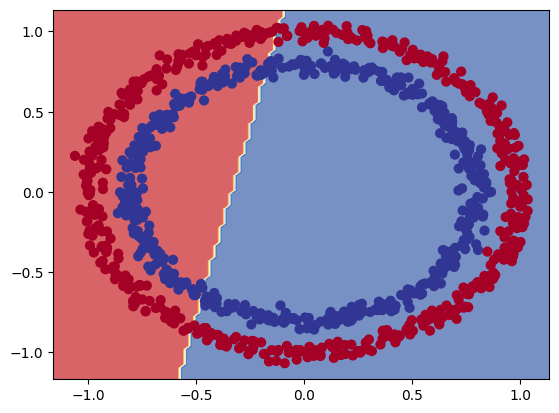

In [11]:
plot_decision_boundary(model, X, y)

In [12]:
EPOCHS = 10000

for epoch in range(EPOCHS):
  ## Training
  model.train()

  # 1. Forward
  y_logits = model(X_train).squeeze()

  y_pred = torch.round(torch.sigmoid(y_logits))

  # 2. Compute los
  loss = loss_fn(y_logits, y_train)

  acc = accuracy_fn(y_train, y_pred)

  # 3. Compute grad (w Backprop) and step
  optimizer.zero_grad()

  loss.backward()

  optimizer.step()

  ## Testing
  model.eval()
  with torch.inference_mode():
    test_logits = model(X_test).squeeze()
    test_pred = torch.round(torch.sigmoid(test_logits))
    test_loss = loss_fn(test_logits, y_test)
    test_acc = accuracy_fn(y_test, test_pred)

  if epoch % int(.1*EPOCHS) == 0:
    print(f"Epoch: {epoch}:\nLoss: {loss:.5f} Acc: {acc:.2f}% | (Test) Loss: {test_loss:.5f} Acc: {test_acc:.2f}%")

Epoch: 0:
Loss: 0.70015 Acc: 51.25% | (Test) Loss: 0.70151 Acc: 51.00%
Epoch: 1000:
Loss: 0.69298 Acc: 51.00% | (Test) Loss: 0.69468 Acc: 46.00%
Epoch: 2000:
Loss: 0.69298 Acc: 51.00% | (Test) Loss: 0.69468 Acc: 46.00%
Epoch: 3000:
Loss: 0.69298 Acc: 51.00% | (Test) Loss: 0.69468 Acc: 46.00%
Epoch: 4000:
Loss: 0.69298 Acc: 51.00% | (Test) Loss: 0.69468 Acc: 46.00%
Epoch: 5000:
Loss: 0.69298 Acc: 51.00% | (Test) Loss: 0.69468 Acc: 46.00%
Epoch: 6000:
Loss: 0.69298 Acc: 51.00% | (Test) Loss: 0.69468 Acc: 46.00%
Epoch: 7000:
Loss: 0.69298 Acc: 51.00% | (Test) Loss: 0.69468 Acc: 46.00%
Epoch: 8000:
Loss: 0.69298 Acc: 51.00% | (Test) Loss: 0.69468 Acc: 46.00%
Epoch: 9000:
Loss: 0.69298 Acc: 51.00% | (Test) Loss: 0.69468 Acc: 46.00%


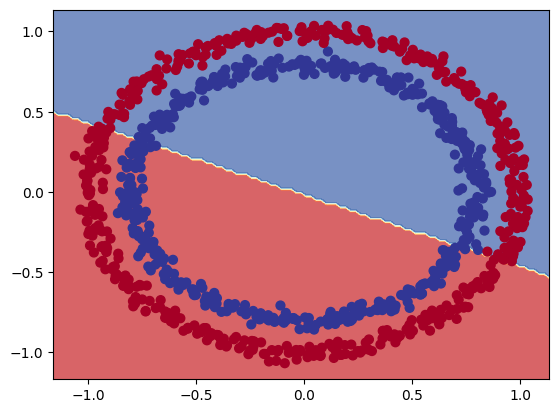

In [13]:
plot_decision_boundary(model, X, y)

## Non Linear

In [14]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)

model_plus = nn.Sequential(
    nn.Linear(in_features=2, out_features=8),
    nn.ReLU(),
    nn.Linear(in_features=8, out_features=1),
).to(device)

loss_fn = nn.BCEWithLogitsLoss()

optimizer = torch.optim.SGD(
    params=model_plus.parameters(),
    lr=0.1
)

model_plus.state_dict()

OrderedDict([('0.weight',
              tensor([[ 0.5406,  0.5869],
                      [-0.1657,  0.6496],
                      [-0.1549,  0.1427],
                      [-0.3443,  0.4153],
                      [ 0.6233, -0.5188],
                      [ 0.6146,  0.1323],
                      [ 0.5224,  0.0958],
                      [ 0.3410, -0.0998]])),
             ('0.bias',
              tensor([ 0.5451,  0.1045, -0.3301,  0.1802, -0.3258, -0.0829, -0.2872,  0.4691])),
             ('2.weight',
              tensor([[-0.2791, -0.1630, -0.0998, -0.2126,  0.0334, -0.3492,  0.3193, -0.3003]])),
             ('2.bias', tensor([0.2730]))])

In [15]:
EPOCHS = 5000

for epoch in range(EPOCHS):
  ## Training
  model_plus.train()

  # 1. Forward
  y_logits = model_plus(X_train).squeeze()

  y_pred = torch.round(torch.sigmoid(y_logits))

  # 2. Compute los
  loss = loss_fn(y_logits, y_train)

  acc = accuracy_fn(y_train, y_pred)

  # 3. Compute grad (w Backprop) and step
  optimizer.zero_grad()

  loss.backward()

  optimizer.step()

  ## Testing
  model_plus.eval()
  with torch.inference_mode():
    test_logits = model_plus(X_test).squeeze()
    test_pred = torch.round(torch.sigmoid(test_logits))
    test_loss = loss_fn(test_logits, y_test)
    test_acc = accuracy_fn(y_test, test_pred)

  if epoch % int(.1 * EPOCHS) == 0:
    print(f"Epoch: {epoch}:\nLoss: {loss:.5f} Acc: {acc:.2f}% | (Test) Loss: {test_loss:.5f} Acc: {test_acc:.2f}%")

Epoch: 0:
Loss: 0.69735 Acc: 48.75% | (Test) Loss: 0.69029 Acc: 53.00%
Epoch: 500:
Loss: 0.67083 Acc: 65.75% | (Test) Loss: 0.66778 Acc: 70.50%
Epoch: 1000:
Loss: 0.61555 Acc: 91.25% | (Test) Loss: 0.62383 Acc: 89.50%
Epoch: 1500:
Loss: 0.50290 Acc: 96.62% | (Test) Loss: 0.53592 Acc: 91.00%
Epoch: 2000:
Loss: 0.35544 Acc: 98.62% | (Test) Loss: 0.40231 Acc: 97.00%
Epoch: 2500:
Loss: 0.23199 Acc: 99.00% | (Test) Loss: 0.28366 Acc: 97.50%
Epoch: 3000:
Loss: 0.15538 Acc: 99.38% | (Test) Loss: 0.20391 Acc: 98.00%
Epoch: 3500:
Loss: 0.11112 Acc: 99.75% | (Test) Loss: 0.15396 Acc: 98.50%
Epoch: 4000:
Loss: 0.08461 Acc: 99.75% | (Test) Loss: 0.12244 Acc: 98.50%
Epoch: 4500:
Loss: 0.06767 Acc: 99.88% | (Test) Loss: 0.10232 Acc: 98.50%


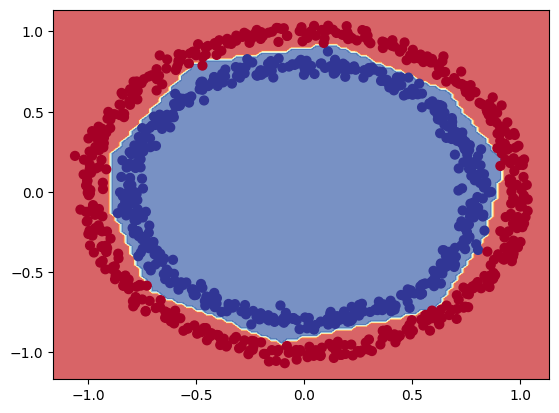

In [16]:
plot_decision_boundary(model_plus, X, y)

# 2. Multiclass Classification

## 1. Data

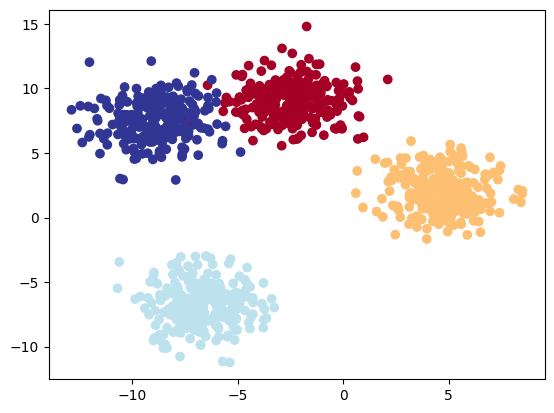

In [17]:
from sklearn.datasets import make_blobs

X, y = make_blobs(n_samples=1000,
                  n_features=2,
                  centers=4,
                  cluster_std=1.5,
                  random_state=42)

X = torch.from_numpy(X).type(torch.float32)
y = torch.from_numpy(y).type(torch.long)

plt.scatter(X[:, 0], X[:, 1], c = y, cmap = plt.cm.RdYlBu)

## 2. Split

In [18]:
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.2, # 20%
                                                    random_state=42)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

(torch.Size([800, 2]),
 torch.Size([200, 2]),
 torch.Size([800]),
 torch.Size([200]))

## 3. Model

In [19]:
class BlobModel(nn.Module):
  def __init__(self, input_features, output_features, hidden_units):
    super().__init__()
    self.linear_layer_stack = nn.Sequential(
        nn.Linear(in_features=input_features, out_features=hidden_units),
        nn.ReLU(),
        nn.Linear(in_features=hidden_units, out_features=hidden_units),
        nn.ReLU(),
        nn.Linear(in_features=hidden_units, out_features=output_features)
    )

  def forward(self, x):
    return self.linear_layer_stack(x)

In [20]:
model = BlobModel(2, 4, 8)
model.state_dict()

OrderedDict([('linear_layer_stack.0.weight',
              tensor([[ 0.1177, -0.2296],
                      [ 0.4370,  0.1102],
                      [ 0.5713,  0.0773],
                      [-0.2230,  0.1900],
                      [-0.1918,  0.2976],
                      [ 0.6313,  0.4087],
                      [-0.3091,  0.4082],
                      [ 0.1265,  0.3591]])),
             ('linear_layer_stack.0.bias',
              tensor([-0.4310, -0.7000, -0.2732, -0.5424,  0.5802,  0.2037,  0.2929,  0.2236])),
             ('linear_layer_stack.2.weight',
              tensor([[-0.0062,  0.2767, -0.2512,  0.0223, -0.2413,  0.1090, -0.1218,  0.1083],
                      [-0.0737,  0.2932, -0.2096, -0.2109, -0.2109,  0.3180,  0.1178,  0.3402],
                      [-0.2918, -0.3507, -0.2766, -0.2378,  0.1432,  0.1266,  0.2938, -0.1826],
                      [-0.2410,  0.1876, -0.1429,  0.2146, -0.0839,  0.2022, -0.2747, -0.1784],
                      [ 0.1078,  0.0747, -0.090

## 4. Loss and Optmizer

In [21]:
loss_fn = nn.CrossEntropyLoss()

optimizer = torch.optim.SGD(
    params=model.parameters(),
    lr=0.1
)

## 5. Training Loop

In [22]:
EPOCHS = 1000

for epoch in range(EPOCHS):
  ## Training
  model.train()

  # 1. Forward
  y_logits = model(X_train)
  y_pred = torch.softmax(y_logits, dim=1).argmax(dim=1)

  # 2. Loss
  loss = loss_fn(y_logits, y_train)
  acc = accuracy_fn(y_train, y_pred)

  # 3. Grad
  optimizer.zero_grad()

  loss.backward()

  # 4. Step
  optimizer.step()

  ## Testing
  model.eval()
  with torch.inference_mode():
    test_logits = model(X_test)
    test_loss = loss_fn(test_logits, y_test)
    test_pred = torch.softmax(test_logits, dim=1).argmax(dim=1)
    test_acc = accuracy_fn(y_test, test_pred)

  if epoch % int(.1 * EPOCHS) == 0:
    print(f"Epoch: {epoch}:\nLoss: {loss:.5f} Acc {acc:.2f}% | (Test) Loss: {test_loss:.5f} Acc: {test_acc:.2f}%")

Epoch: 0:
Loss: 1.43567 Acc 25.00% | (Test) Loss: 1.31794 Acc: 24.50%
Epoch: 100:
Loss: 0.15037 Acc 99.12% | (Test) Loss: 0.14756 Acc: 99.50%
Epoch: 200:
Loss: 0.04887 Acc 99.12% | (Test) Loss: 0.03972 Acc: 99.50%
Epoch: 300:
Loss: 0.02729 Acc 99.25% | (Test) Loss: 0.01757 Acc: 99.50%
Epoch: 400:
Loss: 0.02454 Acc 99.25% | (Test) Loss: 0.01437 Acc: 99.50%
Epoch: 500:
Loss: 0.02341 Acc 99.25% | (Test) Loss: 0.01300 Acc: 99.50%
Epoch: 600:
Loss: 0.02274 Acc 99.25% | (Test) Loss: 0.01215 Acc: 99.50%
Epoch: 700:
Loss: 0.02227 Acc 99.25% | (Test) Loss: 0.01152 Acc: 99.50%
Epoch: 800:
Loss: 0.02189 Acc 99.25% | (Test) Loss: 0.01104 Acc: 99.50%
Epoch: 900:
Loss: 0.02157 Acc 99.25% | (Test) Loss: 0.01063 Acc: 99.50%


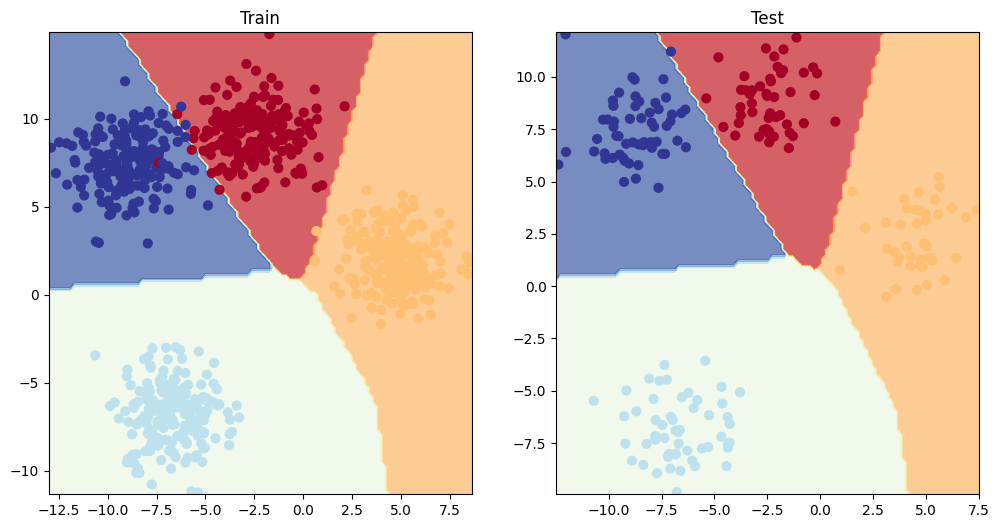

In [29]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model, X_train, y_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model, X_test, y_test)

Accuracy: 99.50%


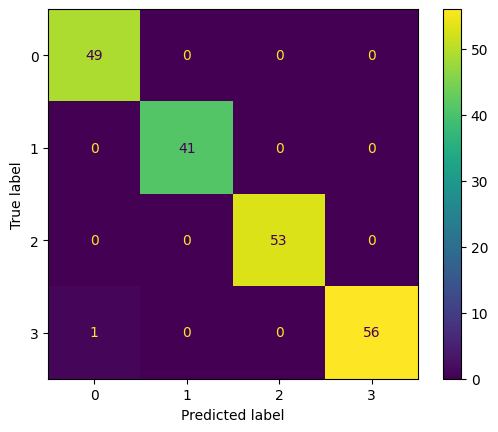

In [30]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score

# Print accuracy
print(f"Accuracy: {accuracy_score(y_test, test_pred)*100:.2f}%")

cm = confusion_matrix(y_test, test_pred)
ConfusionMatrixDisplay(cm).plot()